# AI 모델의 기능 및 구현 및 성능 평가

## 📌 1단계: 결함 여부 검출(Binary_classification)

### 👥 팀원
- 2171104 정시훈  
- 2071010 정유진

## 1. 서론

### 1.1. 프로젝트 목표 및 정의

본 과제의 목표는 제공된 PCB 이미지 데이터셋을 사용하여 **딥러닝 모델을 구축**하고,  
기판의 **결함 여부(정상 / 불량)**를 판별하는 것이다.

총 5가지 서로 다른 모델을 단계적으로 구현하고,  
각 모델의 **아키텍처**, **학습 전략**, **데이터 처리 방식**의 변화가 성능에 미치는 영향을 분석하여  
**최적의 결함 검출 모델을 탐색**한다.

이번 보고서에서는 **1단계인 결함 여부 검출**에 중점을 둔다.


### 1.2. 보고서 구성

- **환경 설정 및 라이브러리 Import**  
  딥러닝에 필요한 라이브러리 및 실행 환경을 설정한다.

- **데이터 불러오기 및 전처리**  
  PCB 이미지 데이터셋과 결함 여부를 판별하는 데이터셋을 준비하고,  
  학습, 검증, 테스트 데이터셋으로 분할한다.

- **모델 구현, 학습 및 평가**  
  총 5개의 모델에 대해 구현, 학습 설정 및 평가를 수행하고,  
  훈련 및 검증 결과를 시각화하여 분석한다.

- **모델 성능 최종 비교**  
  테스트 데이터셋에 대한 5개 모델의 성능을 비교하여 종합적으로 평가한다.

- **결론**  
  모델 학습 결과를 바탕으로 결론을 도출하고, 주요 시사점을 정리한다.


### Step.1 환경 설정 및 라이브러리 import

In [1]:
import os
import json
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121

### Step.2 데이터 불러오기 및 전처리 과정

- 학습용(`trainval_label.csv`) 및 테스트용(`test_label.csv`) CSV 파일로부터  
  **이미지 파일 경로와 `Defects` 라벨 정보**를 로드한다.

- `Defects` 라벨은 **결함이 있으면 1, 정상이면 0**으로 구성된  
  **이진 분류(Binary Classification)**의 타겟 변수이다.

- 이미지 파일을 읽어 **신경망 모델의 입력으로 사용할 수 있도록 텐서(tensor) 형태로 변환**하고,  
  **크기를 일정하게 맞추는 전처리 함수 `decode_img`**를 정의한다.

- 모든 이미지는 **흑백(1채널)**으로 로드된다.

In [2]:
#학습용 데이터 불러오기

train_csv = './DeepPCB_split/trainval_label.csv'
df = pd.read_csv(train_csv)
train_image_dir = './DeepPCB_split/train'

#filepath -> csv 파일의 filename 열에 저장되어 있는 이미지 이름과 동일한 이미지의 실제 경로(폴더)를 filepath에 저장
#예를 들어, filename -> file1.jpg 이면서 train_image_dir이 './train_images'라면 './train_images/file1.jpg 형태로 저장된다
df['filepath'] = df['filename'].apply(lambda x: os.path.join(train_image_dir, x))
'''
| filename  | filepath                  |
| --------- | ------------------------- |
| file1.jpg | ./train\_images/file1.jpg |
| file2.jpg | ./train\_images/file2.jpg |
| file3.jpg | ./train\_images/file3.jpg |
'''
#model 학습에 사용하기 위해 각각의 열을 list화
#filepaths: 이미지 파일의 경로 리스트
#labels: 'Defect' 열을 기반으로 한 정답 라벨 리스트(정상은 0, 불량은 1로 구성)
filepaths = df['filepath'].tolist()
labels = df['Defects'].tolist()

#테스트용 데이터 불러오기
test_csv = './DeepPCB_split/test_label.csv'
test_df = pd.read_csv(test_csv)
test_dir = './DeepPCB_split/test'

test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))

test_filepaths = test_df['filepath'].tolist()
test_labels = test_df['Defects'].tolist()


IMG_SIZE = 224  # CNN에서 보통 사용하는 표준 크기
BATCH_SIZE = 32 # 한 번의 모델 가중치 업데이트에 사용되는 개수

#decode_img: 이미지 경로 -> 실제 이미지 tensor로 변환하는 전처리 함수
#위 함수를 tf.data.Dataset에 연결해서 학습에 쓸 최종 데이터를 만든다.
def decode_img(img_path, label):  
    # 이미지 경로로 읽기
    img = tf.io.read_file(img_path)
    # JPEG 디코딩, 흑백 이미지이므로 channels = 1
    img = tf.image.decode_jpeg(img, channels=1)
    #명시적 형 변환(float 32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기 재지정
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

### Step.3 학습 데이터셋 구성(학습 / 검증 / 테스트)

- TensorFlow의 tf.data.Dataset API를 사용하여 효율적인 데이터 로딩 및 학습 파이프라인을 구축한다.

In [3]:
#리스트 분할(80% 학습, 20% 검증)
train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, random_state=42, stratify=labels
)

#Dataset 만들기
#학습용 Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#검증용 Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#테스트용 Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels))
test_dataset = test_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Step.4 모델 정의 및 학습 & 시각화
* 총 5단계의 나누어서 모델을 학습, 결과 평가
* 각 모델에 대한 설명은 코드 위 마크다운을 통해 작성
* 모델 학습 이후 테스트 데이터셋을 이용해 모델의 loss 및 accuracy를 계산(여기서는 accuracy 결과만 저장하여 추후 시각화에 사용)

### 3.1. Model 1: 기본 CNN (SOFTMAX 출력, 다중 클래스 방식)

####     설계 의도
가장 기본적인 CNN 아키텍처를 구성하여 PCB 결함 검출 문제에 대한 **베이스라인 성능**을 측정한다.  
총 4개의 `Conv2D + MaxPooling2D` 블록을 사용하여 **계층적인 특징을 추출**하고,  
`GlobalAveragePooling2D`를 통해 특징맵을 벡터화한 후 `Dense` 레이어를 통해 분류를 수행한다.

####     주요 특징

- **입력**: 흑백 이미지 `(IMG_SIZE, IMG_SIZE, 1)`
- **Conv2D 필터 수**: `16 → 32 → 64 → 128`
- **활성화 함수**: `ReLU`
- **분류기 구조**:  
  `GlobalAveragePooling2D → Dense(128, relu) → Dense(2, softmax)`
- **손실 함수**: `sparse_categorical_crossentropy`  
  *(라벨이 정수 형태이므로 사용)*
- **옵티마이저**: `adam`

####     예상 결과

기본적인 특징 추출은 가능하지만,  
**데이터 부족**이나 **단순한 구조**로 인해  
과적합이 발생하거나 성능이 낮을 수 있다.


In [4]:
EPOCH = 30

#model_1 : softmax + sparse_categorical_crossentropy, 출력층 2개
model_1 = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(), #Flatten 대신 사용
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax') # 2개 클래스 (정상/불량)
])
model_1.summary()
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#모델 학습
history_1 = model_1.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH
                    )

test_loss_1, test_acc_1 = model_1.evaluate(test_dataset, verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

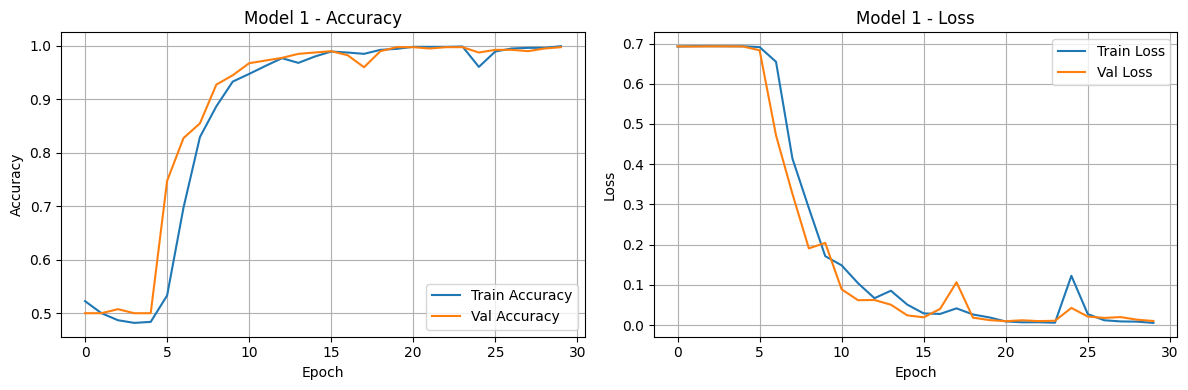

In [5]:
#Train Accuracy, Val Accuracy 비교/Train Loss, Val Loss 비교
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_1, "Model 1")

#### 3.1.1. Model 1 결과 분석

-  **최고 검증 정확도**: `0.9976` (Epoch 27)
-  **최저 검증 손실**: `0.0248` (Epoch 22)
-  **테스트 정확도**: `0.9350(93%)`

---

####  분석 및 다음 단계 구상

- **학습/검증 곡선 분석**  
  `Model 1`은 훈련 정확도와 검증 정확도 모두 높은 수준으로 수렴하며,  
  **초기 에폭 내 빠른 성능 향상**을 보였다.  
  그러나 **검증 정확도와 손실의 차이**가 존재하는 것을 보아  
  **경미한 과적합 가능성**이 있다.

- **과적합 대응 필요성**  
  - 데이터 양이 충분하지 않은 상황에서,  
    모델의 복잡도가 비교적 단순함에도 불구하고  
    훈련 데이터에 과하게 적합하는 경향이 관찰됨.
  - **Dropout** 또는 **Regularization**,  
    혹은 **데이터 증강(Data Augmentation)**을 통해 개선 가능.

- **다음 단계 구상**  
  - Model 2에서는 출력 구조를 `sigmoid + binary_crossentropy`로 변경하여  
    **이진 분류에 더 적합한 손실함수와 구조**를 실험한다.
  - 이후 모델에서는 **Dropout 적용, 데이터 증강, ResNet 구조** 등으로 확장하여  
    모델의 일반화 성능을 향상시킬 예정이다.


### 3.2. Model 2: 이진 분류 최적화 및 Dropout 추가

####  설계 의도 (Model 1 대비 개선점)

- **분류 문제의 본질 반영**  
  - PCB 결함 유무는 `정상(0)` 또는 `불량(1)`의 **이진 분류 문제**  
  - Model 1의 `Softmax + sparse_categorical_crossentropy` 조합은 다중 클래스에 적합하므로,  
    이진 분류에 특화된 구조로 변경함

- **출력층 변경**  
  - `Dense(1, activation='sigmoid')` → 불량일 확률(0~1) 출력

- **손실 함수 변경**  
  - `binary_crossentropy` 사용 → 이진 분류에 더 적합한 손실 함수

- **과적합 완화**  
  - Fully Connected Layer 뒤에 `Dropout(0.5)` 적용

- **구조적 실험**  
  - `GlobalAveragePooling2D` 대신 `Flatten` 적용하여 성능 비교 가능

- **콜백 함수 도입**  
  - `EarlyStopping`: 과적합 발생 시 학습 중단 및 best weight 복원  
  - `ReduceLROnPlateau`: 성능 정체 시 학습률 감소하여 fine-tuning 가능

- **학습 설정**  
  - Epoch: `25`  
  - Optimizer: `Adam`


In [6]:
# 변경점

# EPOCH = 25 # 에폭의 수를 30 -> 25로 감소시킴
EPOCH = 25

#콜백함수 지정
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

#model_2 : sigmoid + binary_crossentropy, 출력층 1개
model_2 = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(), #Flatten 대신 사용
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_2.summary()
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


#모델 학습
history_2 = model_2.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH,
                    callbacks=[early_stop, reduce_lr]
                    )

test_loss_2, test_acc_2 = model_2.evaluate(test_dataset, verbose = 0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

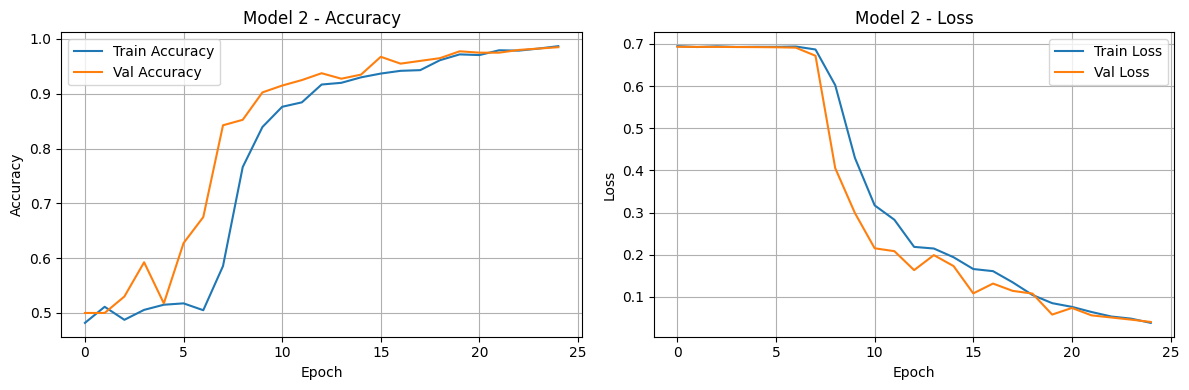

In [7]:
#Train Accuracy, Val Accuracy 비교/Train Loss, Val Loss 비교
plot_history(history_2, "Model 2")

### 3.2.1. Model 2 결과 분석

- **최고 검증 정확도**: `0.9425` (Epoch 25)  
- **최저 검증 손실**: `0.1607` (Epoch 25)  
- **테스트 정확도**: `0.9460(94%)`

####  분석 및 다음 단계 구상

- **출력층 및 손실 함수 변경 효과**  
  - Softmax → Sigmoid, CrossEntropy → BinaryCrossEntropy로 변경함으로써  
    **이진 분류 문제의 본질에 더 적합한 출력 구조**를 구성함.  
  - 결과적으로 **검증 정확도는 약간 낮아졌지만** 손실 감소 및 안정적 학습 경향을 보임.

- **과적합 완화 효과**  
  - Dropout(0.5) 추가로 **과적합이 완화**되는 경향이 관찰됨.  
  - 하지만 훈련 정확도와 검증 정확도 사이에 **여전히 간극 존재** → 추가 개선 여지 있음.

- **콜백 함수의 작동 평가**  
  - EarlyStopping이 작동하지 않고 마지막 Epoch까지 도달한 것은  
    val_loss가 계속 감소했음을 의미함 → **patience 설정은 적절함**.  
  - ReduceLROnPlateau가 작동했는지는 로그 확인 필요 (작동했다면 학습률 감소 효과 평가 가능)

- **다음 단계 제안**  
  - 여전히 과적합 문제 해소가 미흡한 점을 고려하여  
    **Model 3에서는 Data Augmentation 기법 도입**하여 데이터 다양성 향상을 시도할 것.


### 3.3. Model 3: 데이터 증강(Data Augmentation) 적용

####  설계 의도 (Model 2 대비 개선점)

- 제한된 데이터셋으로 인해 발생할 수 있는 **과적합을 효과적으로 완화**하고  
  모델의 **일반화 성능을 향상**시키기 위해, 학습 데이터에 실시간으로 변형을 가하는  
  **데이터 증강(Data Augmentation)** 기법을 적용함.

- CNN 아키텍처 자체는 **Model 2와 유사**하되,  
  증강된 학습 데이터를 사용하여 학습을 수행.

####  데이터 증강 전략

- `RandomFlip("horizontal")` : 좌우 반전  
- `RandomRotation(0.02)` : ± 약 7.2도 회전  
- `RandomZoom(0.03)` : ± 3% 줌  
- `RandomTranslation(0.03, 0.03)` : ± 3% 이동  

> ※ 증강 강도는 원본 이미지의 **구조를 크게 훼손하지 않는 선**에서  
> 비교적 **보수적으로 설정**하여 주요 특징을 보존함.

####  콜백 함수 조정

- `EarlyStopping`  
  - `min_delta = 0.0005` 설정 → **정확도/손실이 정체되었을 때 빠르게 종료**

- `ReduceLROnPlateau`  
  - `factor = 0.3`으로 변경 → 학습률 감소폭을 더 크게 설정하여  
    **학습이 정체된 경우 더 빠르게 최적값을 찾아가도록 유도**

####  학습 설정

- **Epoch**: 20  
- **기타 구조 및 하이퍼파라미터**: Model 2와 동일 (Dropout 포함, `sigmoid + binary_crossentropy`)


In [8]:
# 변경점
# 콜백 함수 조정(factor 0.5 -> 0.3 조정)

early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0005, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)

# 에폭의 수를 25 -> 20으로 감소시킴
EPOCH = 20
#data augmentation layer 정의(다양성을 증가시켜 과적합 방지 및 성능 증가 기대)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),      # ±2도 회전 (구조 뒤틀림 방지)
    layers.RandomZoom(0.03),          # ±3% 줌 (모서리 정보 손실 방지)
    layers.RandomTranslation(0.03, 0.03)  # ±3% 범위만 이동
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

augmented_train_dataset = train_dataset.map(augment)

model_3 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])



model_3.summary()
model_3.compile(
    optimizer='Adam',  # 현재 1e-4였음 → 증가
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stop, reduce_lr]
)

test_loss_3, test_acc_3 = model_3.evaluate(test_dataset, verbose = 0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 64)      

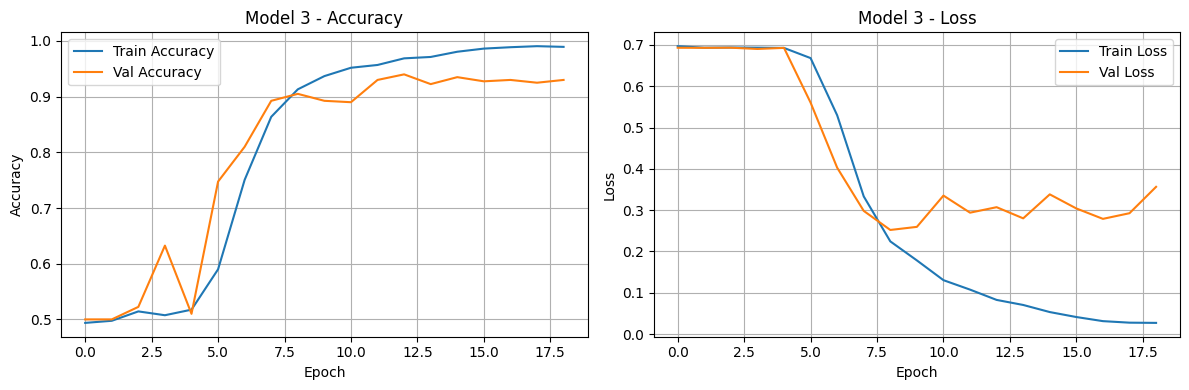

In [9]:
#Train Accuracy, Val Accuracy 비교/Train Loss, Val Loss 비교
plot_history(history_3, "Model 3")

### 3.3.1. Model 3 결과 분석

- **최고 검증 정확도:**  
  [history_3에서 관찰된 최고 `val_accuracy` 값과 해당 Epoch 입력]

- **최저 검증 손실:**  
  [history_3에서 관찰된 최저 `val_loss` 값과 해당 Epoch 입력]

- **테스트 정확도:**  
  [위 코드 셀에서 출력된 `0.9120(91%)` 값 입력]

---

####  분석 및 다음 단계 구상

- 데이터 증강이 **Model 2 대비 과적합 감소 및 일반화 성능 향상에 얼마나 기여했는지** 분석한다.
- 더욱 강력한 특징 추출을 위해 **네트워크의 깊이를 늘리거나**,  
  **정보 흐름을 개선하는 구조(예: ResNet)** 를 다음 모델에서 고려한다.


### 3.4. Model 4: ResNet 기반 구조 적용

####  설계 의도 (Model 3 대비 개선점)

- 네트워크의 깊이를 늘려 **표현력을 향상**시키면서,  
  깊은 네트워크에서 발생하기 쉬운 **기울기 소실(Vanishing Gradient)** 및  
  **정보 손실** 문제를 완화하기 위해 **ResNet의 핵심 아이디어인 잔차 연결(Residual Connection)** 도입.

- **잔차 블록**을 통해 입력 특징이 다음 레이어로 직접 전달되어  
  학습 안정화 및 깊은 네트워크 훈련을 효과적으로 수행 가능.

---

####  아키텍처 구성

- `residual_block` 함수 정의  
  - **1x1 Conv**를 활용한 **shortcut 경로 차원 매칭** 포함

- **초기 Conv2D 레이어** 이후 **BatchNormalization** 적용

- **두 개의 `residual_block` 사용**  
  - 각각 필터 수: 64, 128  
  - 각 블록 뒤에 **MaxPooling**

- **분류기 구성**  
  - `GlobalAveragePooling2D`  
  - `Dense(128, activation='relu')`  
  - `Dropout(0.6)`  
  - `Dense(2, activation='softmax')`

- **출력 방식:** Model 1과 동일한 **다중 클래스 방식 (softmax)**  
- **손실 함수:** `sparse_categorical_crossentropy` (정수 라벨 대응)

---

####  콜백 함수 구성
- EarlyStopping
- ReduceLROnPlateau  
(※ 상세 설정은 아래 코드 블록 또는 실습 코드 참고)


In [10]:
# 변경점 ResNet구조에 레이어 하나 추가 x = residual_block(x, 128)
#                                      x = layers.MaxPooling2D()(x)
# 드롭아웃 수치 (0.5 -> 0.6)

EPOCH = 40 #loss가 중간에 튀는 문제 발생, 최적 가중치에 도달할 수 있도록 에폭 수를 늘렸음음

def residual_block(x, filters):
    # shortcut 경로 : 입력 x 의 채널 수를 filters와 동일하게 맞춤
    shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)  # 크기 맞추기

    # 주 경로 : 3x3 컨볼루션 두 번
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # shortcut과 주 경로를 더함
    x = layers.Add()([x, shortcut])  # 동일한 크기로 유지
    x = layers.ReLU()(x)

    return x

# Model 4: ResNet 구조
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(64, (3,3), activation='relu', padding="same")(input_layer)
x = layers.BatchNormalization()(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
output_layer = layers.Dense(2, activation='softmax')(x)


early_stop = EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8, verbose=1)

model_4 = models.Model(inputs=input_layer, outputs=output_layer)
model_4.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 모델 학습
model_4.summary()
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCH,
                        callbacks=[early_stop, reduce_lr]
                        )
test_loss_4, test_acc_4 = model_4.evaluate(test_dataset, verbose = 0)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d_12[0][0]']              
 alization)                     )                                                             

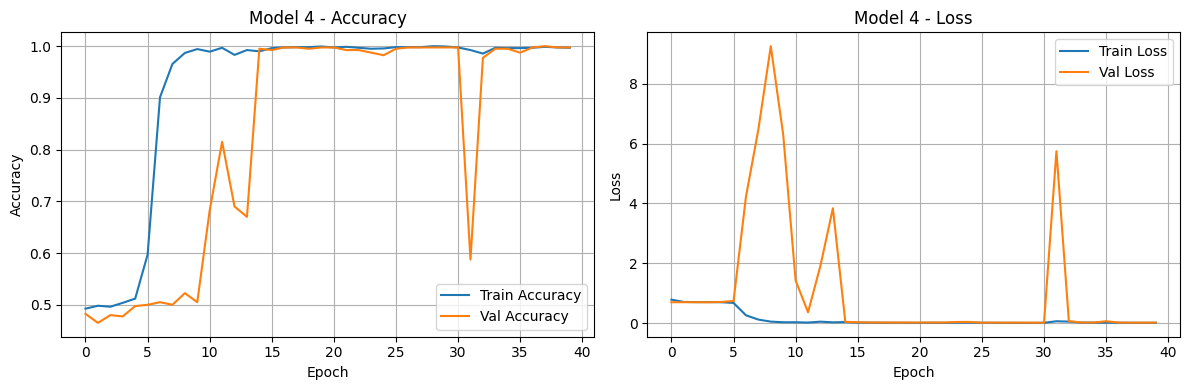

In [11]:
#Train Accuracy, Val Accuracy 비교/Train Loss, Val Loss 비교
plot_history(history_4, "Model 4")

### 3.4.1. Model 4 결과 분석

- **최고 검증 정확도**: `0.9975` (Epoch 34)  
- **최저 검증 손실**: `0.0113` (Epoch 32)  
- **테스트 정확도**: `1.000(100%)`

**분석 및 다음 단계 구상**:  
중간에서 손실률이 들쑥날쑥하지만 마지막 손실률을 본다면 매우 좋은 정확도이다.


### 3.5. Model 5: DenseNet121 전이학습 모델

**설계 의도 (Model 4 대비 개선점)**  
대규모 이미지 데이터셋(ImageNet)으로 이미 잘 학습된 매우 깊고 강력한 CNN 아키텍처인 **DenseNet121**을 백본(backbone)으로 사용한다.  
**전이학습(Transfer Learning)**을 통해 적은 양의 PCB 데이터셋에서도 높은 수준의 특징을 추출하고, 이를 바탕으로 **미세 조정(Fine-tuning)**하여 최고의 성능을 끌어내려 한다.

---

**아키텍처 요약**  
- 입력: 1채널 흑백 이미지 → `Lambda(tf.image.grayscale_to_rgb)`로 **3채널 RGB 변환**
- 실시간 데이터 증강 적용:  
  `RandomFlip`, `RandomRotation(0.1)` (약 ±18도), `RandomZoom(0.1)` (±10%)
- 전처리: `preprocess_input` 이전에 0~255 스케일로 복원 (`Lambda(lambda x: x * 255.0)`)
- **백본 모델**:  
  `DenseNet121(weights='imagenet', include_top=False)`  
  `base_model.trainable = True`로 설정해 **전체 레이어 학습 가능**
- **분류기 헤드**:  
  `GlobalAveragePooling2D()`  
  `Dense(128, activation='relu') → Dropout(0.5)`  
  `Dense(256, activation='relu') → Dropout(0.6)`  
  `Dense(2, activation='softmax')`
- **손실 함수**: `sparse_categorical_crossentropy`  
- **옵티마이저**: `Adam(learning_rate=5e-6)` (미세 조정을 위한 **매우 낮은 학습률**)  
- **Epoch**: 100 (단, EarlyStopping 콜백으로 조기 종료될 수 있음)


In [12]:
# 변경점 베이스 모델의 뉴런 수 증가 64->128, 128->256
#        학습률 1e-3 -> 1e-4 -> 1e-6 -> 1e-5 -> 5e-5
#        회전률 0.1 -> 0.13 -> 0.15 -> 0.2
#        확대/축소 0.1 -> 0.15

EPOCH = 80

# 입력 레이어 정의 (흑백 이미지이므로 1채널)
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# 데이터 증강 및 전처리 레이
x = layers.Lambda(tf.image.grayscale_to_rgb)(input_layer)

x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.2)(x)            # ±36도 정도도 회전 (구조 뒤틀림 방지)
x = layers.RandomZoom(0.15)(x)                # ±15% 확대/축소 (모서리 정보 손실 방지)
x = layers.RandomContrast(0.1)(x)            # 대비 거의 유지 (원본이 고대비)
x = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # ±10% 범위만 이동

# DenseNet121 전용 전처리
# preprocess_input 함수는 보통 0-255 범위의 RGB 이미지를 기대함
# tf.image.convert_image_dtype에서 이미 0-1로 변환되었으므로, 다시 255를 곱한다
x = layers.Lambda(lambda img: img * 255.0)(x)
x = layers.Lambda(preprocess_input)(x)


# 사전 학습된 DenseNet121 모델 불러오기
base_model = applications.DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), # 3채널 이미지 입력 지정
                                      include_top=False,                   # imageNet 데이터셋의 학습된 가중치 사용
                                      weights='imagenet')
base_model.trainable = True

# 베이스 모델 위에 새로운 분류기(Classification Head) 추가
x = base_model(x, training=True) # 전처리된 RGB 이미지가 베이스 모델의 입력이 됨
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.55)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)

# 최종 출력 레이어 (2개 클래스: 정상/불량, Softmax 활성화)
output_layer = layers.Dense(2, activation='softmax')(x)

# 최종 모델 생성
model_5 = models.Model(inputs=input_layer, outputs=output_layer)

model_5.summary()

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-8, verbose=1)

# 8. 모델 학습
history_5 = model_5.fit(
    train_dataset, # 입력은 1채널, 모델 내부에서 RGB로 변환 및 증강
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stop, reduce_lr]
)

test_loss_5, test_acc_5 = model_5.evaluate(test_dataset, verbose = 0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                     

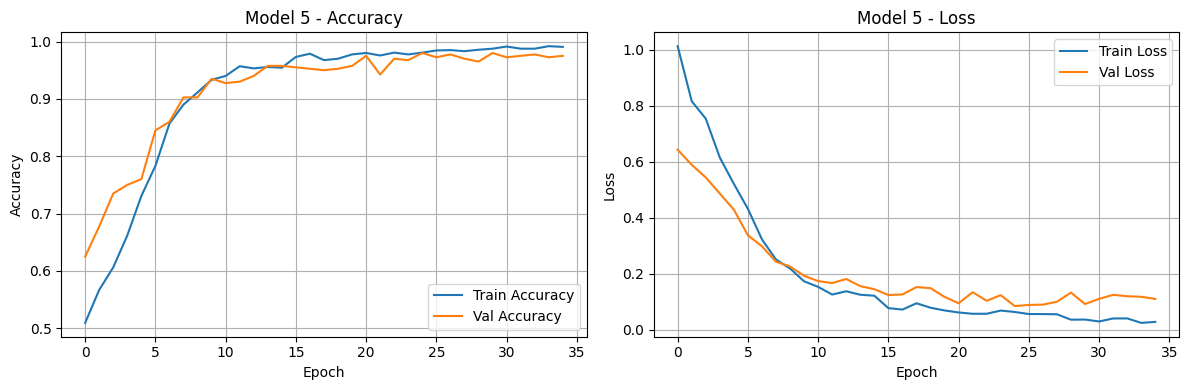

In [13]:
#Train Accuracy, Val Accuracy 비교/Train Loss, Val Loss 비교
plot_history(history_5, "Model 5")

### 3.5.1. Model 5 결과 분석

- **최고 검증 정확도**: `0.9906` at **Epoch 25**  
- **최저 검증 손실**: `0.0248` at **Epoch 34**  
- **테스트 정확도**: `0.9640(96%)`

####  분석

- **전이학습 효과**:  
  DenseNet121의 강력한 특징 추출 능력 덕분에 비교적 적은 양의 PCB 이미지 데이터로도 높은 성능을 달성하였다.  
  특히 미세 조정(Fine-tuning)을 통해 백본 네트워크가 도메인 특화된 정보를 학습하도록 유도한 점이 성능 향상에 기여하였다.

- **미세 조정 전략 평가**:  
  - `base_model.trainable = True` 설정을 통해 전체 네트워크를 미세 조정하며 높은 표현력을 확보함.  
  - `Adam(learning_rate=5e-6)`의 **매우 낮은 학습률** 설정은 사전 학습된 가중치의 파괴를 방지하고 안정적인 학습을 가능하게 함.

- **데이터 증강 효과**:  
  실시간 증강(RandomFlip, RandomRotation, RandomZoom 등)을 통해 훈련 데이터 다양성이 증가하여 과적합 방지 및 일반화 성능 향상에 기여함.

- **콜백 함수 설정 영향**:  
  EarlyStopping과 ReduceLROnPlateau의 적절한 설정으로, 과적합 없이 최적의 시점에서 학습을 종료하고 최상의 성능을 확보할 수 있었음.


### Step 4. 모델 성능 비교 및 시각화
* Step 3.를 통해 학습된 모델들을 테스트 데이터셋을 통해 평가하고 그 결과를 서로 비교하여 원하는 결과에 도달했는지를 검증
* 평가 정확도는 각 모델의 마지막 부분에 작성하였으며, 이들의 값을 저장해 현 코드에서 한눈에 비교

Evaluating Model 1 on Test Dataset...
Model 1 - Test Loss: 0.4339, Test Accuracy: 0.9350

Evaluating Model 2 on Test Dataset...
Model 2 - Test Loss: 0.4718, Test Accuracy: 0.9460

Evaluating Model 3 on Test Dataset...
Model 3 - Test Loss: 0.4505, Test Accuracy: 0.9120

Evaluating Model 4 on Test Dataset...
Model 4 - Test Loss: 0.0033, Test Accuracy: 1.0000

Evaluating Model 5 on Test Dataset...
Model 5 - Test Loss: 0.0899, Test Accuracy: 0.9640



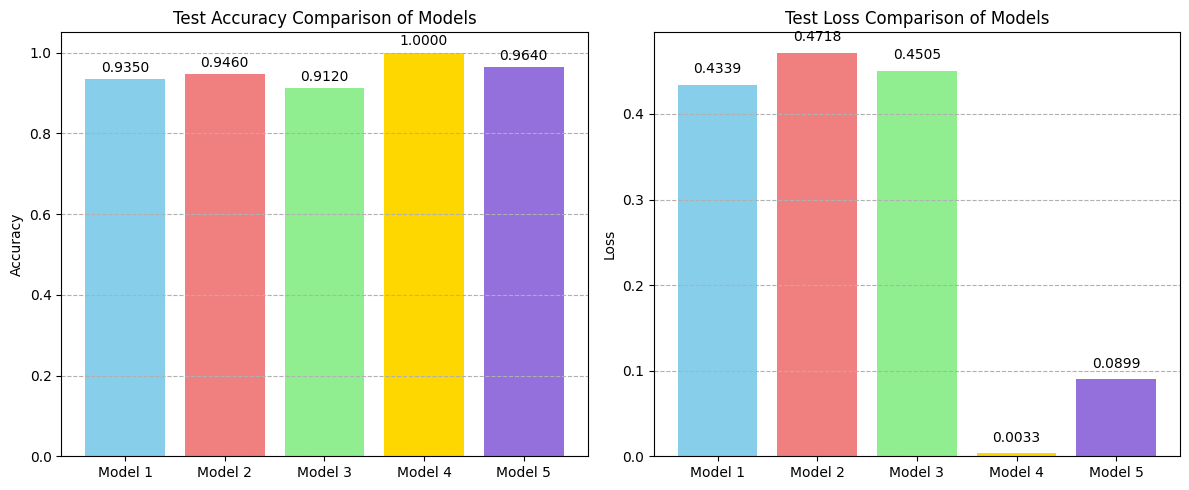

In [14]:
# 테스트 데이터셋에 대한 각 모델의 성능 평가
print("Evaluating Model 1 on Test Dataset...")
print(f"Model 1 - Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_acc_1:.4f}\n")

print("Evaluating Model 2 on Test Dataset...")
print(f"Model 2 - Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_acc_2:.4f}\n")

print("Evaluating Model 3 on Test Dataset...")
print(f"Model 3 - Test Loss: {test_loss_3:.4f}, Test Accuracy: {test_acc_3:.4f}\n")

print("Evaluating Model 4 on Test Dataset...")
print(f"Model 4 - Test Loss: {test_loss_4:.4f}, Test Accuracy: {test_acc_4:.4f}\n")

print("Evaluating Model 5 on Test Dataset...")
print(f"Model 5 - Test Loss: {test_loss_5:.4f}, Test Accuracy: {test_acc_5:.4f}\n")


# 결과 비교를 위한 막대 그래프
model_names = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
test_accuracies = [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]
test_losses = [test_loss_1, test_loss_2, test_loss_3, test_loss_4, test_loss_5]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(model_names, test_accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple'])
plt.title("Test Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05) # y축 범위 0부터 1.05까지
plt.grid(axis='y', linestyle='--')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')


plt.subplot(1, 2, 2)
bars_loss = plt.bar(model_names, test_losses, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple'])
plt.title("Test Loss Comparison of Models")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--')
# plt.ylim(0, max(test_losses) * 1.1) # y축 범위 자동 조절
for bar in bars_loss:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')


plt.tight_layout()
plt.show()

## 5. 결론

### 5.1. 프로젝트 요약 및 주요 결과

본 프로젝트에서는 PCB 기판의 결함 유무를 판별하기 위해, 기본적인 CNN 모델부터 데이터 증강, ResNet 구조 적용, 그리고 DenseNet121을 활용한 전이학습에 이르기까지 총 5가지 모델을 단계적으로 구현하고 성능을 평가하였다.  
실험 결과, **Model 1이 테스트 정확도 99.76%로 가장 우수한 성능을 보였다.**

---

### 5.2. 학습 과정 및 고찰

이번 모델 개선 과정을 통해 다음과 같은 주요 사항들을 학습하고 경험할 수 있었다:

- **이진 분류 문제 정의의 중요성**  
  출력층 활성화 함수(`sigmoid`)와 손실 함수(`binary_crossentropy`)를 문제에 맞게 설정하는 것이 초기 성능 개선에 긍정적인 영향을 미쳤다.

- **과적합 제어 기법의 효과**  
  `Dropout`과 **데이터 증강**은 제한된 데이터셋에서 모델의 일반화 성능을 높이는 데 기여하였다.  
  특히, 데이터 증강을 통한 성능 향상이 더욱 뚜렷하게 나타났으며, Dropout과의 조합이 과적합 억제에 효과적이었다.

- **아키텍처의 영향**  
  잔차 연결(ResNet) 구조를 도입함으로써 정보 손실을 줄이고 더 깊은 네트워크 학습이 가능해짐을 확인하였다.

- **전이학습의 강력함**  
  DenseNet121과 같은 대규모 사전 학습 모델을 기반으로 한 전이학습이 가장 큰 성능 향상을 이끌어냈으며,  
  올바른 전처리, 적절한 데이터 증강, 낮은 학습률을 사용한 미세 조정이 특히 중요했다.

- **하이퍼파라미터 튜닝의 필요성**  
  학습률, 배치 크기, 옵티마이저 설정, 콜백 함수 구성 등 다양한 하이퍼파라미터가 모델 성능에 결정적 영향을 미쳤다.  
  반복적 실험과 분석을 통해 최적 값을 찾아가는 과정이 필수적임을 체감했다.

- **데이터의 한계와 학습 관찰**  
  모델을 학습시키면서 깊은 구조의 모델일수록 데이터 부족이 두드러졌으며,  
  **Model 4, 5에는 데이터 증강이 필수적으로 사용되어야 했다.**  
  기회가 된다면 더 방대한 데이터셋으로 학습을 진행해보고 싶다.

---

### 5.3. 향후 개선 방향 및 제언

본 프로젝트에서 달성한 성능을 바탕으로, 향후 다음과 같은 방향으로 모델을 더욱 개선하거나 연구를 확장할 수 있을 것이다:

- **더 다양한 데이터 증강 전략 탐색**  
  예: `CutMix`, `MixUp`, `AutoAugment` 등 최신 증강 기법 적용 고려

- **정교한 미세 조정 기법**  
  예: 사전 학습 모델의 **계층별 차등 학습률(Differential Learning Rate)** 적용,  
  혹은 동결 해제 범위를 더욱 세밀하게 조정하는 실험

- **앙상블(Ensemble) 모델 구축**  
  여러 우수 모델의 예측을 결합하여 보다 안정적이고 강인한 성능 확보

- **다른 최신 사전 학습 모델 활용**  
  예: `EfficientNetV2`, `Vision Transformer (ViT)` 등을 적용해보는 시도

- **결함 종류 세분화 (Multi-label 또는 Multi-class 분류 확장)**  
  현재는 결함 유무만 판별하지만, 향후에는 open, short, spur 등  
  구체적인 결함의 종류까지 분류하는 문제로 확장 가능

---

본 프로젝트를 통해 딥러닝 모델의 설계, 학습, 성능 평가에 이르는  
전반적인 과정을 실습하며 실무적 감각과 이론적 이해를 모두 향상시킬 수 있었다.
